In [1]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nba_api.stats.endpoints import leaguedashplayerstats, synergyplaytypes
from nba_api.stats.endpoints import teamyearbyyearstats, playercareerstats
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow, Rectangle
import matplotlib.ticker as mtick
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import functools
import seaborn as sns
import glob
from sklearn import preprocessing
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import gamma, exponpow, lognorm, cauchy, genhyperbolic
from datetime import date
from PIL import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('fivethirtyeight')

from scipy.stats import gamma, exponpow, lognorm, cauchy
from sklearn.mixture import BayesianGaussianMixture
import json

import warnings
warnings.filterwarnings('ignore')

/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_17774/1140703441.py:30: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [23]:
def convert_season_to_int(season):
    season = season.split('-')[0]
    return int(season) + 1

def convert_int_to_season(year):
    previos_year = year - 1
    year = str(year)
    previous_year = str(previos_year)
    year = year[-2:]
    return f'{previos_year}-{year}'

if_regular_season = True
first_year = 2000
last_year = 2024

stats_df = pd.DataFrame()

if_regular_season = True

for year in tqdm(range(first_year, last_year + 1)):
    season_year = convert_int_to_season(year)
    if if_regular_season:
        season_type = 'Regular Season'
    else:
        season_type = 'Playoffs'

    basic_stats = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense='Base',
                                                          season_type_all_star='Regular Season',
                                                          season=season_year,
                                                          per_mode_detailed='PerGame'
                                                         ).get_data_frames()[0]
    
    time.sleep(0.5)
    
    advanced_stats = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense='Advanced',
                                                          season_type_all_star='Regular Season',
                                                          season=season_year,
                                                          per_mode_detailed='PerGame',
                                                         ).get_data_frames()[0]

    curr_stats_df = pd.merge(basic_stats, advanced_stats, on=['PLAYER_NAME', 'PLAYER_ID'])
    
    curr_stats_df['Season'] = season_year

    stats_df = pd.concat([stats_df, curr_stats_df])
    
    time.sleep(0.5)

100%|███████████████████████████████████████████| 25/25 [00:36<00:00,  1.44s/it]


In [27]:
def z(data):
    mean = np.mean(data)
    std = np.std(data)

    return (data - mean) / std

def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i], scale=covars[i])
    return mcdf

def calc_h_score_3(data, clf):
    probs = mix_norm_cdf(data, means=clf.means_.flatten(), covars=clf.covariances_.flatten(), weights=clf.weights_)
    h_scores = stats.norm.ppf(probs)
    return h_scores

def calc_h_score(data, cat):
    # TODO fix points <= 2.58
    if cat == 'p/g':
        data[cat] = np.maximum(2.58, data[cat].values)
    probs = cat_dist_dict[cat].cdf(data[cat].values)
    h_scores = stats.norm.ppf(probs)
    if cat == 'to/g':
        return -h_scores
    return h_scores

def calc_perc_h_score(data, cat):
    cat_a = cat.replace('%', 'a/g')
    shots_made = data[cat].values * data[cat_a].values
    perc_avg = shots_made.sum() / data[cat_a].sum()
    impact = (data[cat] - perc_avg) * data[cat_a]

    probs = cat_dist_dict[cat].cdf(impact)

    h_scores = stats.norm.ppf(probs)

    return h_scores

def calc_pm_h_score(values):
    loc= -0.41520750959232705
    scale= 1.8825247000642065

    rv = stats.hypsecant(loc = loc, scale = scale)
    probs = rv.cdf(values)
    h_scores = stats.norm.ppf(probs)
    return h_scores

In [24]:
stats_df

,PLAYER_ID,PLAYER_NAME,NICKNAME_x,TEAM_ID_x,TEAM_ABBREVIATION_x,AGE_x,GP_x,W_x,L_x,W_PCT_x,...,E_PACE_RANK,PACE_RANK,sp_work_PACE_RANK,PIE_RANK,FGM_RANK_y,FGA_RANK_y,FGM_PG_RANK,FGA_PG_RANK,FG_PCT_RANK_y,Season
0,920,A.C. Green,A.C.,1610612747,LAL,36.0,82,67,15,0.817,...,298,354,354,205,201,199,262,267,171,1999-00
1,1920,A.J. Bramlett,A.J.,1610612739,CLE,23.0,8,3,5,0.375,...,19,17,17,432,413,401,416,362,430,1999-00
2,243,Aaron McKie,Aaron,1610612755,PHI,27.0,82,49,33,0.598,...,256,210,210,142,146,133,180,163,300,1999-00
3,1425,Aaron Williams,Aaron,1610612764,WAS,28.0,81,29,52,0.358,...,303,303,303,96,151,177,184,227,33,1999-00
4,228,Adam Keefe,Adam,1610612762,UTA,30.0,62,41,21,0.661,...,432,414,414,367,321,318,383,386,308,1999-00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,1628380,Zach Collins,Zach,1610612759,SAS,26.0,17,3,14,0.176,...,166,260,260,218,70,83,93,106,117,2023-24
482,203897,Zach LaVine,Zach,1610612741,CHI,28.0,18,5,13,0.278,...,393,437,437,131,30,22,41,38,266,2023-24
483,1630192,Zeke Nnaji,Zeke,1610612743,DEN,22.0,19,13,6,0.684,...,426,395,395,363,275,282,335,361,157,2023-24
484,1630533,Ziaire Williams,Ziaire,1610612763,MEM,22.0,16,4,12,0.250,...,207,305,305,273,179,150,188,159,370,2023-24


In [4]:
# JUST FOR THIS SEASON

# basic_stats = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense='Base',
#                                                           season_type_all_star='Regular Season',
#                                                           season='2023-24',
#                                                           per_mode_detailed='PerGame'
#                                                          ).get_data_frames()[0]

# time.sleep(0.5)

# advanced_stats = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense='Advanced',
#                                                           season_type_all_star='Regular Season',
#                                                           season='2023-24',
#                                                           per_mode_detailed='PerGame',
#                                                          ).get_data_frames()[0]

# stats_df = pd.merge(basic_stats, advanced_stats, on=['PLAYER_NAME', 'PLAYER_ID'])

In [18]:
for column in stats_df.columns:
    print(column)

PLAYER_ID
PLAYER_NAME
NICKNAME_x
TEAM_ID_x
TEAM_ABBREVIATION_x
AGE_x
GP_x
W_x
L_x
W_PCT_x
MIN_x
FGM_x
FGA_x
FG_PCT_x
FG3M
FG3A
FG3_PCT
FTM
FTA
FT_PCT
OREB
DREB
REB
AST
TOV
STL
BLK
BLKA
PF
PFD
PTS
PLUS_MINUS
NBA_FANTASY_PTS
DD2
TD3
WNBA_FANTASY_PTS
GP_RANK_x
W_RANK_x
L_RANK_x
W_PCT_RANK_x
MIN_RANK_x
FGM_RANK_x
FGA_RANK_x
FG_PCT_RANK_x
FG3M_RANK
FG3A_RANK
FG3_PCT_RANK
FTM_RANK
FTA_RANK
FT_PCT_RANK
OREB_RANK
DREB_RANK
REB_RANK
AST_RANK
TOV_RANK
STL_RANK
BLK_RANK
BLKA_RANK
PF_RANK
PFD_RANK
PTS_RANK
PLUS_MINUS_RANK
NBA_FANTASY_PTS_RANK
DD2_RANK
TD3_RANK
WNBA_FANTASY_PTS_RANK
NICKNAME_y
TEAM_ID_y
TEAM_ABBREVIATION_y
AGE_y
GP_y
W_y
L_y
W_PCT_y
MIN_y
E_OFF_RATING
OFF_RATING
sp_work_OFF_RATING
E_DEF_RATING
DEF_RATING
sp_work_DEF_RATING
E_NET_RATING
NET_RATING
sp_work_NET_RATING
AST_PCT
AST_TO
AST_RATIO
OREB_PCT
DREB_PCT
REB_PCT
TM_TOV_PCT
E_TOV_PCT
EFG_PCT
TS_PCT
USG_PCT
E_USG_PCT
E_PACE
PACE
PACE_PER40
sp_work_PACE
PIE
POSS
FGM_y
FGA_y
FGM_PG
FGA_PG
FG_PCT_y
GP_RANK_y
W_RANK_y
L_RANK_y
W_PCT_R

<Axes: xlabel='PLUS_MINUS', ylabel='Count'>

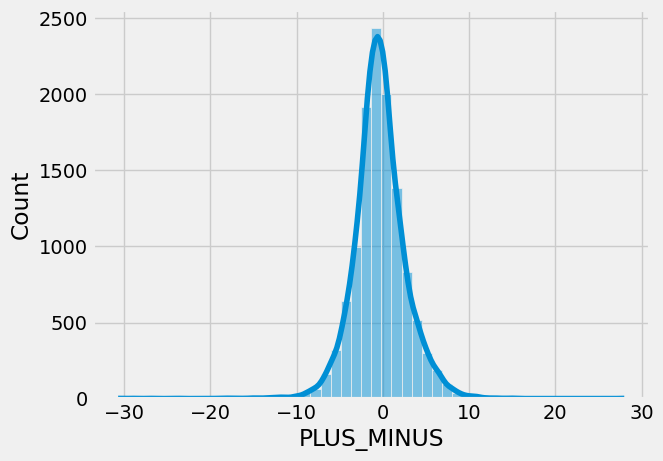

In [25]:
# 3s still questionable
columns = ['PLAYER_NAME', 'PLAYER_ID', 'PTS', 'REB', 'AST', 'FT_PCT', 'FG_PCT_x', 'FGA_x', 'FTA', 'TOV', 'STL', 'BLK', 'PLUS_MINUS']

# stats_df = pd.merge(basic_stats, advanced_stats, on=['PLAYER_NAME', 'PLAYER_ID'])

names_dict = {
            'PTS':'p/g',
            'REB':'r/g',
            'AST':'a/g',
            'BLK':'b/g',
            'STL':'s/g',
            'TOV':'to/g',
            # 'FGM_x':'fgm/g',
            'FGA_x':'fga/g',
            'FTA':'fta/g',
            # 'FTM':'ftm/g',
            'FG_PCT_x':'fg%',
            'FT_PCT':'ft%'
}

# stats[columns].sort_values(by=['PLUS_MINUS'], ascending=False)

stats_df = stats_df.rename(columns=names_dict, errors="raise")

# sns.swarmplot(data=stats, y='PLUS_MINUS', orient='v')

sns.histplot(data=stats_df.PLUS_MINUS, bins=50, kde=True)

In [34]:
# stats[]

# stats_df['fg%'] = stats_df['fgm/g'] / stats_df['fga/g']
# stats_df['ft%'] = stats_df['ftm/g'] / stats_df['fta/g']

columns = ['PLAYER_NAME', 'PLUS_MINUS', 'Season']

columns.extend(list(names_dict.values()))
# columns.extend(['fg%', 'ft%'])

h_score_df = stats_df[columns]

h_score_df

,PLAYER_NAME,PLUS_MINUS,Season,p/g,r/g,a/g,b/g,s/g,to/g,fga/g,fta/g,fg%,ft%
0,A.C. Green,4.0,1999-00,5.0,5.9,1.0,0.2,0.6,0.6,4.7,1.2,0.447,0.695
1,A.J. Bramlett,-5.3,1999-00,1.0,2.8,0.0,0.0,0.1,0.4,2.6,0.0,0.190,0.000
2,Aaron McKie,0.6,1999-00,8.0,3.0,2.9,0.2,1.3,1.4,7.2,1.8,0.411,0.829
3,Aaron Williams,0.4,1999-00,7.6,5.0,0.7,1.1,0.5,1.0,5.6,2.5,0.522,0.726
4,Adam Keefe,-0.6,1999-00,2.2,2.2,0.5,0.2,0.3,0.7,2.1,0.6,0.408,0.806
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,Zach Collins,-6.4,2023-24,14.1,6.3,3.8,0.8,0.7,2.8,10.8,2.8,0.503,0.787
482,Zach LaVine,-5.4,2023-24,21.0,4.9,3.4,0.2,0.9,2.0,16.6,4.6,0.443,0.866
483,Zeke Nnaji,-4.1,2023-24,3.7,2.3,0.4,0.5,0.2,0.5,2.7,1.5,0.490,0.607
484,Ziaire Williams,-7.3,2023-24,9.1,4.8,1.4,0.3,0.5,1.3,8.2,1.5,0.389,0.875


In [35]:
dist_dict = {'gamma': gamma,
             'lognorm': lognorm,
             'exponpow': exponpow,
             'cauchy': cauchy,
             'genhyperbolic': genhyperbolic
            }

cat_dist_dict = {}

player = {}

cnt = 1

plot = False


with open('9cat_parameters.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith('#'):
            continue
        else:
            cat, str_dict, error = line.replace(' ', '').split('_')
            str_dict = str_dict.replace("'", '"')
            par_dict = json.loads(str_dict)
            dist = list(par_dict.keys())[0]

            cat_dist_dict[cat] = dist_dict[dist](*list(par_dict[dist].values()))

clf = BayesianGaussianMixture(n_components=2)

clf.means_ = np.array([[1.66894348, 0.07495573]])
clf.covariances_ = np.array([[0.7040092, 0.0212879]])
clf.weights_ = np.array([0.82865659, 0.17134341])

# df_2023 = pd.read_excel(filename)
# df_2023 = extract_projections_from_page()

# h_score_df = all_players.copy()

cats = ['p/g',
        # '3/g',
        'r/g',
        'a/g',
        's/g',
        'b/g',
        'to/g',
        'ft%',
        'fg%',
        'to/g',
        'PLUS_MINUS']

for cat in cats:
    if '%' in cat:
        h_score_df[f'{cat}_hV'] = calc_perc_h_score(h_score_df, cat)
    elif 'PLUS_MINUS' == cat:
        h_score_df[f'PLUS_MINUS_hV'] = calc_pm_h_score(h_score_df.PLUS_MINUS)
    elif '3' in cat:
        h_score_df['3/g_hV'] = calc_h_score_3(h_score_df['3/g'], clf)
    else:
        h_score_df[f'{cat}_hV'] = calc_h_score(h_score_df, cat)

h_scores_columns = []

for column_name in cats:
    column_name = f'{column_name}_hV'
    h_scores_columns.append(column_name)

h_score_df['CARUSO'] = h_score_df[h_scores_columns].mean(axis=1)

h_score_df.sort_values(by=['CARUSO'], ascending=False).head(20)

,PLAYER_NAME,PLUS_MINUS,Season,p/g,r/g,a/g,b/g,s/g,to/g,fga/g,...,p/g_hV,r/g_hV,a/g_hV,s/g_hV,b/g_hV,to/g_hV,ft%_hV,fg%_hV,PLUS_MINUS_hV,CARUSO
430,Shai Gilgeous-Alexander,8.8,2023-24,30.5,6.0,6.1,0.9,2.4,2.3,20.8,...,2.180979,0.343296,1.284995,2.782107,0.786405,-0.778418,1.837468,3.332951,2.592527,1.358389
29,Anthony Davis,3.9,2014-15,24.4,10.2,2.2,2.9,1.5,1.4,17.6,...,1.515857,1.618690,-0.253066,1.306843,2.414887,0.298189,1.134259,3.016951,1.521190,1.287199
403,Shawn Marion,5.1,2005-06,21.8,11.8,1.8,1.7,2.0,1.5,16.9,...,1.196314,1.976450,-0.544551,2.191103,1.662463,0.155539,0.811067,2.776827,1.825378,1.220613
26,Anthony Davis,2.4,2018-19,25.9,12.0,3.9,2.4,1.6,2.0,18.3,...,1.689292,2.017884,0.601178,1.499699,2.147014,-0.464165,1.066170,2.731466,1.078624,1.190300
29,Anthony Davis,3.9,2017-18,28.1,11.1,2.3,2.6,1.5,2.2,19.5,...,1.931371,1.825973,-0.187856,1.306843,2.260168,-0.677605,1.432415,3.156002,1.521190,1.189090
267,Kevin Durant,11.5,2016-17,25.1,8.3,4.8,1.6,1.1,2.2,16.5,...,1.597702,1.117598,0.917210,0.428803,1.577849,-0.677605,1.553742,2.955165,3.052377,1.184524
233,Kevin Garnett,7.5,2003-04,24.2,13.9,5.0,2.2,1.5,2.6,19.6,...,1.492167,2.381597,0.979643,1.306843,2.024277,-1.060420,0.836938,2.410214,2.345443,1.165628
371,Nikola Jokic,7.8,2023-24,29.0,13.2,9.2,0.7,1.2,3.1,19.9,...,2.026625,2.253465,1.921295,0.666661,0.449299,-1.474357,1.008579,3.805723,2.404260,1.158719
401,Shawn Marion,7.5,2006-07,17.5,9.8,1.7,1.5,2.0,1.4,13.4,...,0.600097,1.520956,-0.626632,2.191103,1.487991,0.298189,0.714887,2.446591,2.345443,1.127681
403,Shawn Marion,8.1,2004-05,19.4,11.3,1.9,1.5,2.0,1.5,15.9,...,0.875686,1.869866,-0.466508,2.191103,1.487991,0.155539,0.977881,1.482058,2.461954,1.119111


[Text(1, 0, 'p/g_hV'),
 Text(2, 0, 'r/g_hV'),
 Text(3, 0, 'a/g_hV'),
 Text(4, 0, 's/g_hV'),
 Text(5, 0, 'b/g_hV'),
 Text(6, 0, 'to/g_hV'),
 Text(7, 0, 'ft%_hV'),
 Text(8, 0, 'fg%_hV'),
 Text(9, 0, 'PLUS_MINUS_hV')]

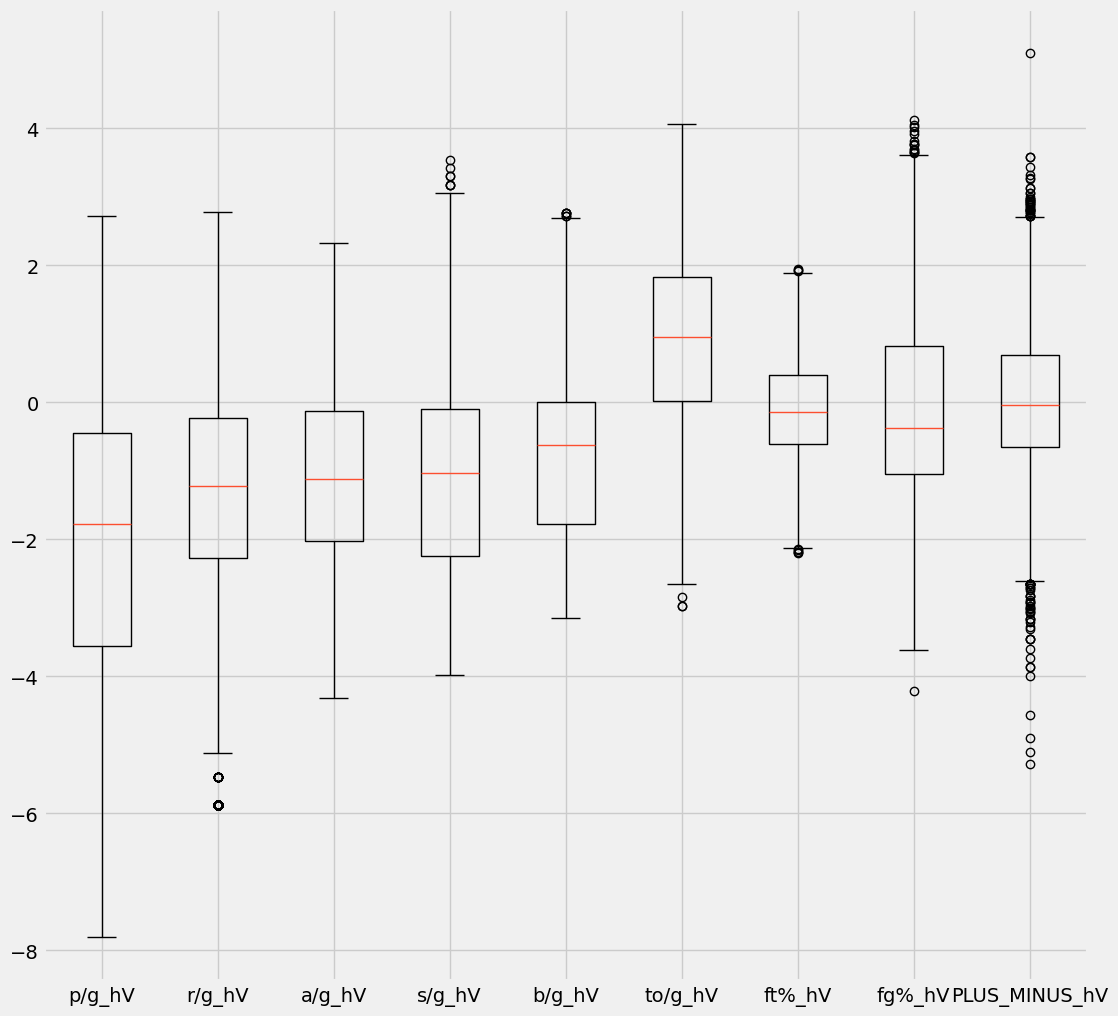

In [36]:
h_score_dict = {}

for column_name in h_scores_columns:
    h_score_dict[column_name] = h_score_df[column_name]
    
fig, ax = plt.subplots(figsize=(12, 12))
ax.boxplot(h_score_dict.values())
ax.set_xticklabels(h_score_dict.keys())

In [37]:
h_score_df

,PLAYER_NAME,PLUS_MINUS,Season,p/g,r/g,a/g,b/g,s/g,to/g,fga/g,...,p/g_hV,r/g_hV,a/g_hV,s/g_hV,b/g_hV,to/g_hV,ft%_hV,fg%_hV,PLUS_MINUS_hV,CARUSO
0,A.C. Green,4.0,1999-00,5.00,5.9,1.0,0.2,0.6,0.6,4.7,...,-2.525991,0.303755,-1.363892,-1.027491,-1.091067,1.824391,-0.495276,-0.166417,1.548007,-0.116959
1,A.J. Bramlett,-5.3,1999-00,2.58,2.8,0.0,0.0,0.1,0.4,2.6,...,-7.803972,-1.374702,-4.321492,-3.313941,-3.143938,2.388528,-0.141049,-1.796639,-1.670178,-1.878885
2,Aaron McKie,0.6,1999-00,8.00,3.0,2.9,0.2,1.3,1.4,7.2,...,-1.341911,-1.226641,0.155497,0.891407,-1.091067,0.298189,0.566905,-1.084927,0.423119,-0.211124
3,Aaron Williams,0.4,1999-00,7.60,5.0,0.7,1.1,0.5,1.0,5.6,...,-1.465935,-0.082235,-1.827743,-1.393477,1.059732,0.956759,-0.487266,1.445577,0.341733,-0.049610
4,Adam Keefe,-0.6,1999-00,2.58,2.2,0.5,0.2,0.3,0.7,2.1,...,-7.803972,-1.877662,-2.234988,-2.241695,-1.091067,1.580510,0.038928,-0.499877,-0.078276,-1.262759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,Zach Collins,-6.4,2023-24,14.10,6.3,3.8,0.8,0.7,2.8,10.8,...,0.042619,0.458420,0.561839,-0.691660,0.627627,-1.233539,0.378432,1.805188,-1.935215,-0.121983
482,Zach LaVine,-5.4,2023-24,21.00,4.9,3.4,0.2,0.9,2.0,16.6,...,1.092462,-0.128903,0.393935,-0.093070,-1.091067,-0.464165,1.355265,-0.578791,-1.695439,-0.167394
483,Zeke Nnaji,-4.1,2023-24,3.70,2.3,0.4,0.5,0.2,0.5,2.7,...,-3.458789,-1.786755,-2.485973,-2.742680,0.009291,2.092021,-0.972974,0.443543,-1.344961,-0.815526
484,Ziaire Williams,-7.3,2023-24,9.10,4.8,1.4,0.3,0.5,1.3,8.2,...,-1.031456,-0.176427,-0.901912,-1.393477,-0.625495,0.448645,0.737180,-1.523409,-2.133938,-0.615164


In [40]:
# h_scores_columns.append('PLAYER_NAME')

# print(h_scores_columns)

h_scores_columns = []

for column_name in cats:
    column_name = f'{column_name}_hV'
    h_scores_columns.append(column_name)
    
h_scores_columns.append('PLAYER_NAME')
h_scores_columns.append('CARUSO')
h_scores_columns.append('Season')

print(h_scores_columns)

h_score_df[h_scores_columns].sort_values(by=['CARUSO'], ascending=True).head(20)
caruso_min, caruso_max = np.min(h_score_df['CARUSO']), np.max(h_score_df['CARUSO'])
h_score_df['Score'] = ((h_score_df['CARUSO'] - caruso_min) / (caruso_max - caruso_min)) * 10

h_scores_columns.append('Score')

h_score_df[h_scores_columns].sort_values(by=['Score'], ascending=False).round(2).head(50)

['p/g_hV', 'r/g_hV', 'a/g_hV', 's/g_hV', 'b/g_hV', 'to/g_hV', 'ft%_hV', 'fg%_hV', 'to/g_hV', 'PLUS_MINUS_hV', 'PLAYER_NAME', 'CARUSO', 'Season']


,p/g_hV,r/g_hV,a/g_hV,s/g_hV,b/g_hV,to/g_hV,ft%_hV,fg%_hV,to/g_hV,PLUS_MINUS_hV,PLAYER_NAME,CARUSO,Season,Score
430,2.18,0.34,1.28,2.78,0.79,-0.78,1.84,3.33,-0.78,2.59,Shai Gilgeous-Alexander,1.36,2023-24,10.00
29,1.52,1.62,-0.25,1.31,2.41,0.30,1.13,3.02,0.30,1.52,Anthony Davis,1.29,2014-15,9.84
403,1.20,1.98,-0.54,2.19,1.66,0.16,0.81,2.78,0.16,1.83,Shawn Marion,1.22,2005-06,9.69
26,1.69,2.02,0.60,1.50,2.15,-0.46,1.07,2.73,-0.46,1.08,Anthony Davis,1.19,2018-19,9.62
29,1.93,1.83,-0.19,1.31,2.26,-0.68,1.43,3.16,-0.68,1.52,Anthony Davis,1.19,2017-18,9.61
267,1.60,1.12,0.92,0.43,1.58,-0.68,1.55,2.96,-0.68,3.05,Kevin Durant,1.18,2016-17,9.60
233,1.49,2.38,0.98,1.31,2.02,-1.06,0.84,2.41,-1.06,2.35,Kevin Garnett,1.17,2003-04,9.56
371,2.03,2.25,1.92,0.67,0.45,-1.47,1.01,3.81,-1.47,2.40,Nikola Jokic,1.16,2023-24,9.54
401,0.60,1.52,-0.63,2.19,1.49,0.30,0.71,2.45,0.30,2.35,Shawn Marion,1.13,2006-07,9.47
403,0.88,1.87,-0.47,2.19,1.49,0.16,0.98,1.48,0.16,2.46,Shawn Marion,1.12,2004-05,9.45


<Axes: xlabel='CARUSO', ylabel='Density'>

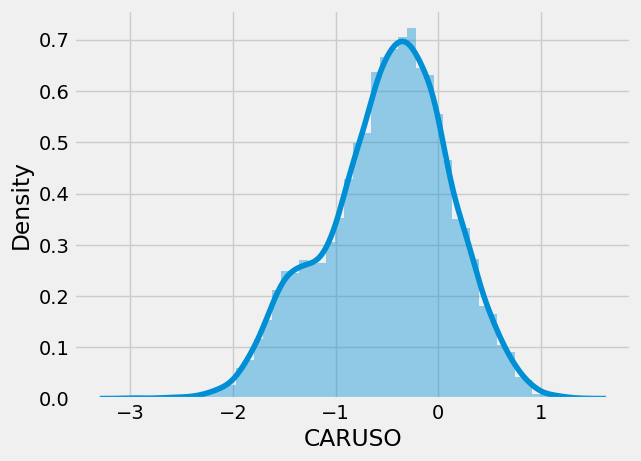

In [41]:
sns.distplot(h_score_df['CARUSO'], kde=True)

In [42]:
sns.swarmplot(data=h_score_df, y='CARUSO', orient='v')

<Axes: ylabel='CARUSO'>

Error in callback <function flush_figures at 0x7fdc4e6bdb80> (for post_execute):



KeyboardInterrupt



<Axes: xlabel='PLUS_MINUS', ylabel='Density'>

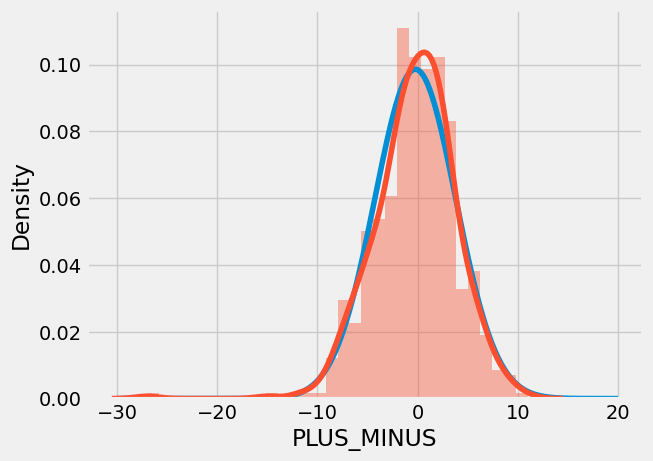

In [16]:
# +/- {'norm': {'loc': -0.23539094650205758, 'scale': 4.04520527940309}}

# pm_values = stats_df.PLUS_MINUS

# loc= -0.23539094650205758
# scale= 4.04520527940309

# x = np.linspace(-30, 20, 1000)

# rv = stats.norm(loc = loc, scale = scale)

# plt.plot(x, rv.pdf(x), label='Fitted')
# sns.distplot(pm_values, kde=True, label='Real')

<Axes: xlabel='PLUS_MINUS', ylabel='Density'>

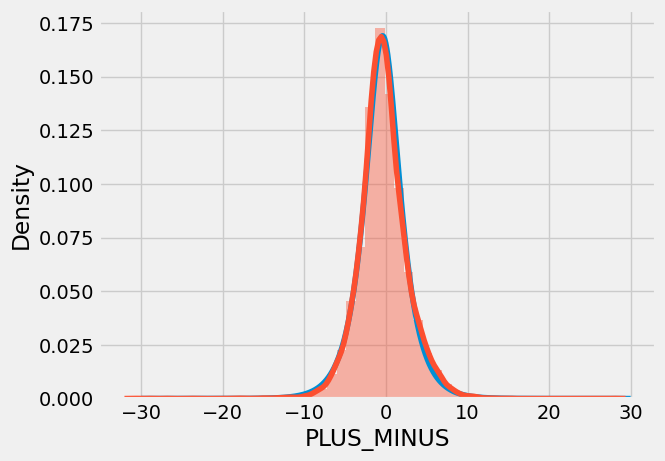

In [25]:
# {'hypsecant': {'loc': -0.41520750959232705, 'scale': 1.8825247000642065}} with error 0.0015582661951897149
# loc= -0.41520750959232705
# scale= 1.8825247000642065

# x = np.linspace(-30, 30, 1000)

# rv = stats.hypsecant(loc = loc, scale = scale)

# plt.plot(x, rv.pdf(x), label='Fitted')
# sns.distplot(pm_values, kde=True, label='True')

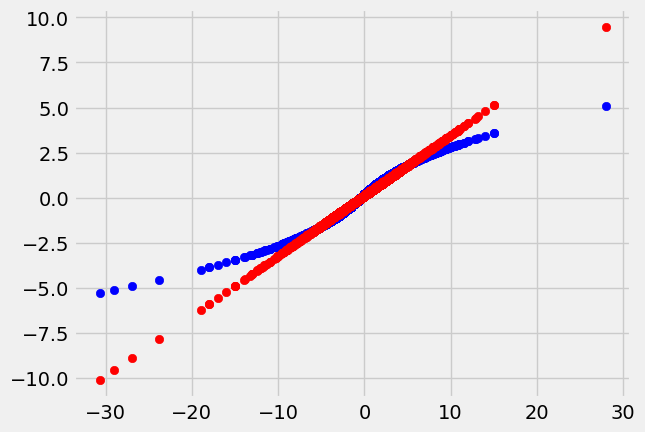

In [47]:
pm_h_score = calc_pm_h_score(pm_values)

mean = np.mean(pm_values)
std_dev = np.std(pm_values)

z = lambda x: (x - mean) / std_dev

plt.scatter(pm_values, pm_h_score, color='b', label='H-score')
plt.scatter(pm_values, z(pm_values), color='r', label='Z-score')
plt.show()

In [91]:
probs = cat_dist_dict['p/g'].cdf([2.58])

h_scores = stats.norm.ppf(probs)

print(h_scores)

points = np.array([1, 2, 4, 6])

print(np.maximum(2.58, points))

[-7.80397172]
[2.58 2.58 4.   6.  ]


In [49]:
all_players.sort_values(by=['PLUS_MINUS'], ascending=False)

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,Season
412,1626154,RJ Hunter,RJ,1610612738,BOS,25.0,1,1,0,1.000,...,25,30,321,54,1,92,261,38,71,2018-19
364,200970,Renaldo Major,Renaldo,1610612744,GSW,25.0,1,0,1,0.000,...,1,2,295,273,1,267,236,17,282,2006-07
461,1628769,Tahjere McCall,Tahjere,1610612751,BKN,24.0,1,0,1,0.000,...,493,196,68,396,2,474,261,38,476,2018-19
468,203915,Spencer Dinwiddie,Spencer,1610612751,BKN,28.0,3,2,1,0.667,...,503,355,244,302,1,251,245,29,247,2020-21
126,203110,Draymond Green,Draymond,1610612744,GSW,26.0,81,73,8,0.901,...,83,21,37,80,1,11,16,2,15,2015-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,203505,Vander Blue,Vander,1610612747,LAL,22.0,2,0,2,0.000,...,18,172,209,133,492,114,252,21,109,2014-15
601,1630285,Zavier Simpson,Zavier,1610612760,OKC,25.0,4,1,3,0.250,...,1,1,147,153,604,64,268,40,90,2021-22
21,1629014,Anfernee Simons,Anfernee,1610612757,POR,24.0,1,0,1,0.000,...,386,153,63,60,486,68,129,9,72,2023-24
64,1628435,Chance Comanche,Chance,1610612757,POR,27.0,1,0,1,0.000,...,499,528,42,271,539,309,253,39,333,2022-23
